When training a model, only with cell_type labels as captions and maximising the similarity between pairs of rna seq and cell type caption, we would expect the resulting embeddings to cluster strongly after cell types. But the observation is strange and there seems to be clustering after tissues.

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif


def compute_contingency_table(adata, celltype_col="cell_type", tissue_col="tissue"):
    """
    Computes a contingency table showing the count of each cell type in each tissue.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object containing metadata in `.obs`.
    celltype_col : str
        Column name for cell type labels in `.obs`.
    tissue_col : str
        Column name for tissue labels in `.obs`.

    Returns
    -------
    pd.DataFrame
        Contingency table (cross-tabulation) of cell types and tissues.
    """
    contingency_table = pd.crosstab(adata.obs[celltype_col], adata.obs[tissue_col])
    return contingency_table


def cramers_v(contingency_table):
    """
    Computes Cramér's V statistic for association between cell types and tissues.

    Parameters
    ----------
    contingency_table : pd.DataFrame
        Cross-tabulation of cell types and tissues.

    Returns
    -------
    float
        Cramér's V value (0 to 1), where higher values indicate stronger association.
    """
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))


def compute_mutual_info(adata, col1="cell_type", col2="tissue"):
    """
    Computes Mutual Information (MI) between cell types and tissues.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object containing metadata in `.obs`.
    col1 : str
        Column name for cell type labels.
    col2 : str
        Column name for tissue labels.

    Returns
    -------
    float
        Mutual information score (higher means stronger dependency).
    """
    cell_types = adata.obs[col1].astype("category").cat.codes
    tissues = adata.obs[col2].astype("category").cat.codes
    mi_score = mutual_info_classif(cell_types.values.reshape(-1, 1), tissues.values)
    return mi_score[0]

In [46]:
from datasets import load_dataset

dataset_name = "cellxgene_pseudo_bulk_3_5k_pairs_cell_type"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
test_dataset = dataset["train"]
# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")["train"]
if "pairs" in dataset_name:
    test_dataset = test_dataset.filter(lambda x: x["label"] == 1.0)

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 755.87it/s]
Generating train split: 6300 examples [00:00, 1022921.77 examples/s]
Generating val split: 700 examples [00:00, 503258.96 examples/s]
Filter: 100%|██████████| 6300/6300 [00:00<00:00, 380405.61 examples/s]


In [4]:
from sentence_transformers import SentenceTransformer

model_name = "mmcontext-3.5k-cell_type-geneformer-2048"
model = SentenceTransformer("jo-mengr/mmcontext-3.5k-cell_type-geneformer-2048")
og_text_encoder = model[0].text_encoder_name
text_encoder = SentenceTransformer(og_text_encoder)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [5]:
from mmcontext.utils import load_test_adata_from_hf_dataset

adata = load_test_adata_from_hf_dataset(test_dataset)

In [39]:
omics_embeddings = model.encode(test_dataset["anndata_ref"])
text_embeddings = model.encode(test_dataset["caption"])
tissue_text_embeddings = model.encode(adata.obs["tissue"].values.tolist())
adata.obsm["tissue_text_emb"] = tissue_text_embeddings
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["og_text_emb"] = text_encoder.encode(test_dataset["caption"])

In [7]:
# Check sample IDs
import json

dataset_sample_ids = [json.loads(row_info)["sample_id"] for row_info in test_dataset["anndata_ref"]]
file_sample_ids = list(adata.obs.index)
if dataset_sample_ids != file_sample_ids:
    print("Sample IDs do not match.")
    print("Dataset sample IDs:", dataset_sample_ids)
    print("File sample IDs:", file_sample_ids)

In [8]:
# check that captions are actual true pos
for row in test_dataset:
    current_caption = row["caption"]
    current_sample_id = json.loads(row["anndata_ref"])["sample_id"]
    assert adata.obs["caption"][current_sample_id] == current_caption
    assert adata.obs["cell_type"][current_sample_id] == current_caption

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/trimap/__init__.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


<Figure size 800x800 with 0 Axes>

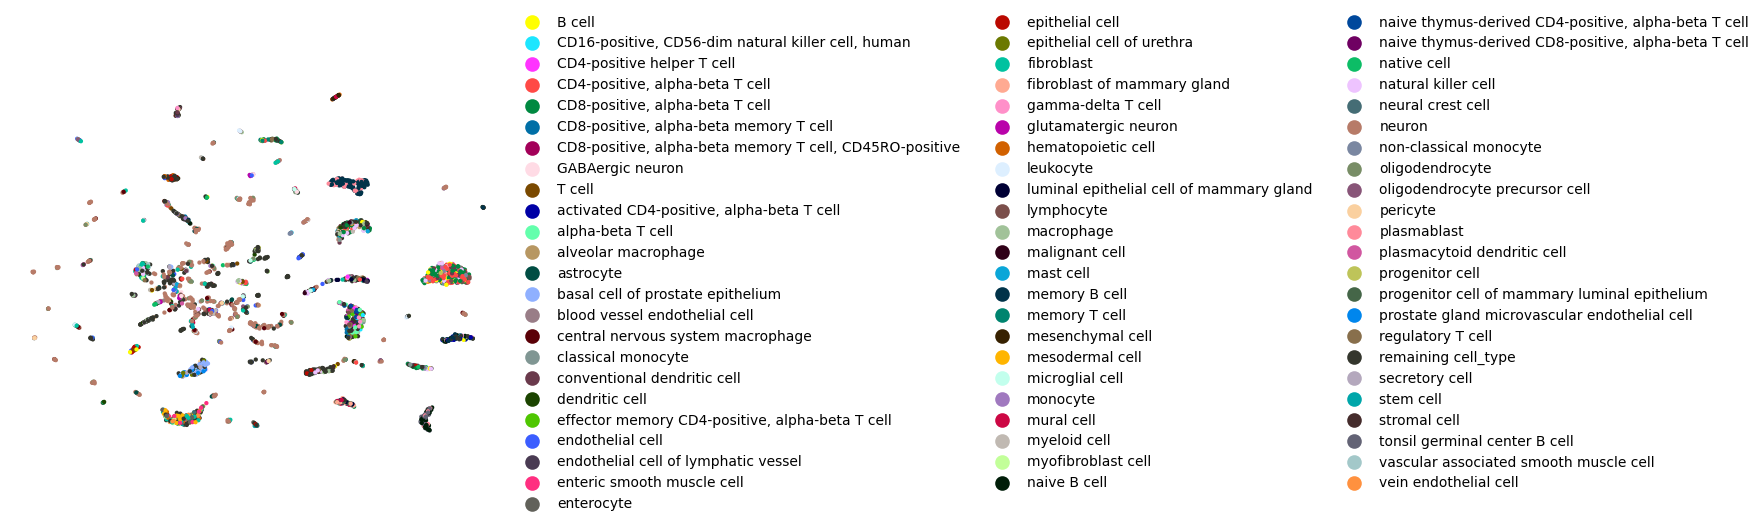

In [11]:
# Visualise the embeddings
from mmcontext.pp.utils import consolidate_low_frequency_categories

from mmcontext.pl import plot_umap

adata_cut = consolidate_low_frequency_categories(adata, ["cell_type"], threshold=10)
label_key = "cell_type"
emb_key = "mmcontext_emb"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

If the mmcontext latent space doesnt cluster after cell_type, what does it cluster after?

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


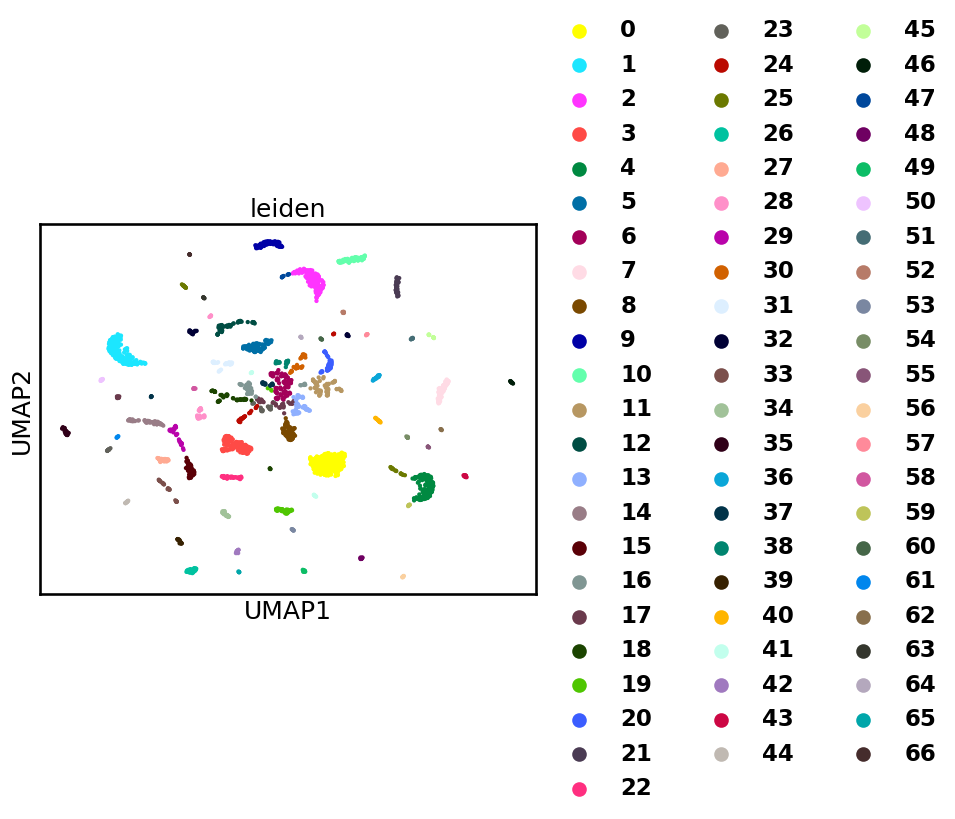

In [12]:
# cluster the mmcontext_emb space with scanpy
import scanpy as sc

sc.pp.neighbors(adata, use_rep="mmcontext_emb")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

In [21]:
for col in ["cell_type", "tissue", "cell_type_ontology_term_id", "assay", "batch", "disease", "Age", "_scvi_batch"]:
    mi_score = compute_mutual_info(adata, col1="leiden", col2=col)
    print(f"MI between leiden and {col}: {mi_score}")

MI between leiden and cell_type: 0.23379473305099996
MI between leiden and tissue: 0.6409216203370929
MI between leiden and cell_type_ontology_term_id: 0.5233175758284467
MI between leiden and assay: 0.1466016394527525
MI between leiden and batch: 0.13072453080997382
MI between leiden and disease: 0.2406325997138965
MI between leiden and Age: 0.017781637842766762
MI between leiden and _scvi_batch: 0.020252260674216593


In [31]:
del adata.uns["cell_type_ontology_term_id_colors"]

<Figure size 800x800 with 0 Axes>

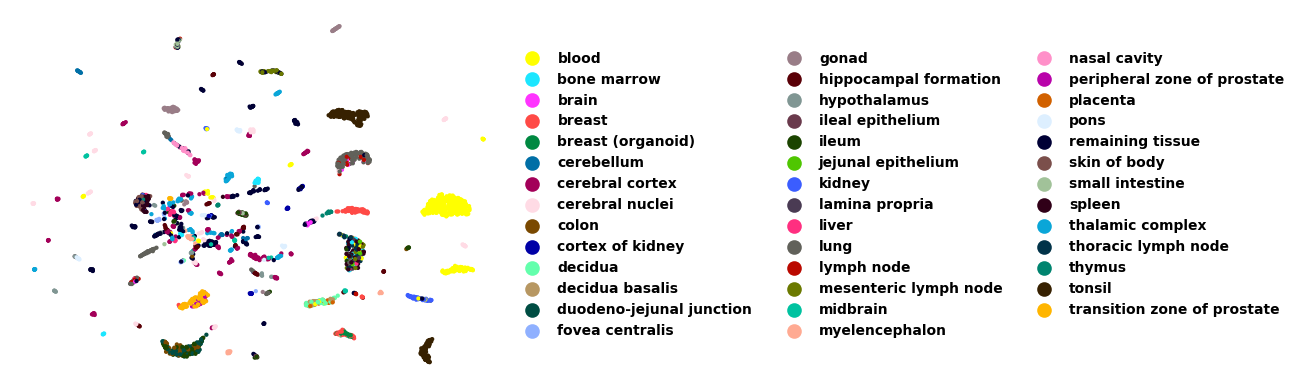

In [36]:
# Visualise the embeddings
from mmcontext.pp.utils import consolidate_low_frequency_categories

from mmcontext.pl import plot_umap

label_key = "tissue"
adata_cut = consolidate_low_frequency_categories(adata, ["tissue"], threshold=0)
emb_key = "mmcontext_emb"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


<Figure size 800x800 with 0 Axes>

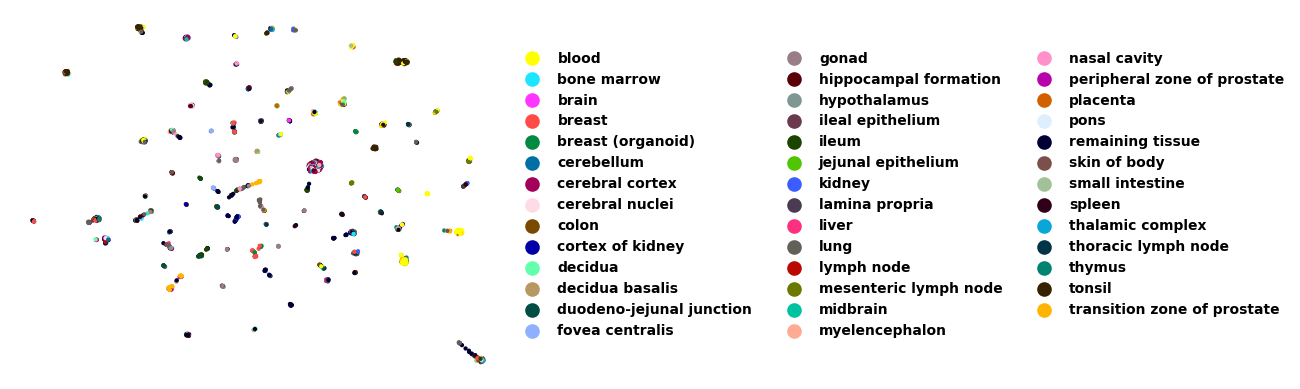

In [34]:
# Does maybe the original text embedding cluster after tissues?
from mmcontext.pp.utils import consolidate_low_frequency_categories

from mmcontext.pl import plot_umap

label_key = "tissue"
adata_cut = consolidate_low_frequency_categories(adata, [label_key], threshold=15)
emb_key = "og_text_emb"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

In [43]:
# is the cosine similarity between the trained omics and text embeddings high? Is it higher for tissues than for cell types?
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=200,
    label_keys=["leiden", "cell_type", "tissue"],
    seed=42,
)
emb_pair_df_tissue = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="tissue_text_emb",
    subset_size=200,
    label_keys=["leiden", "cell_type", "tissue"],
    seed=42,
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base_row[label_key] = adata.obs[label_key][sampled_indices[idx]]


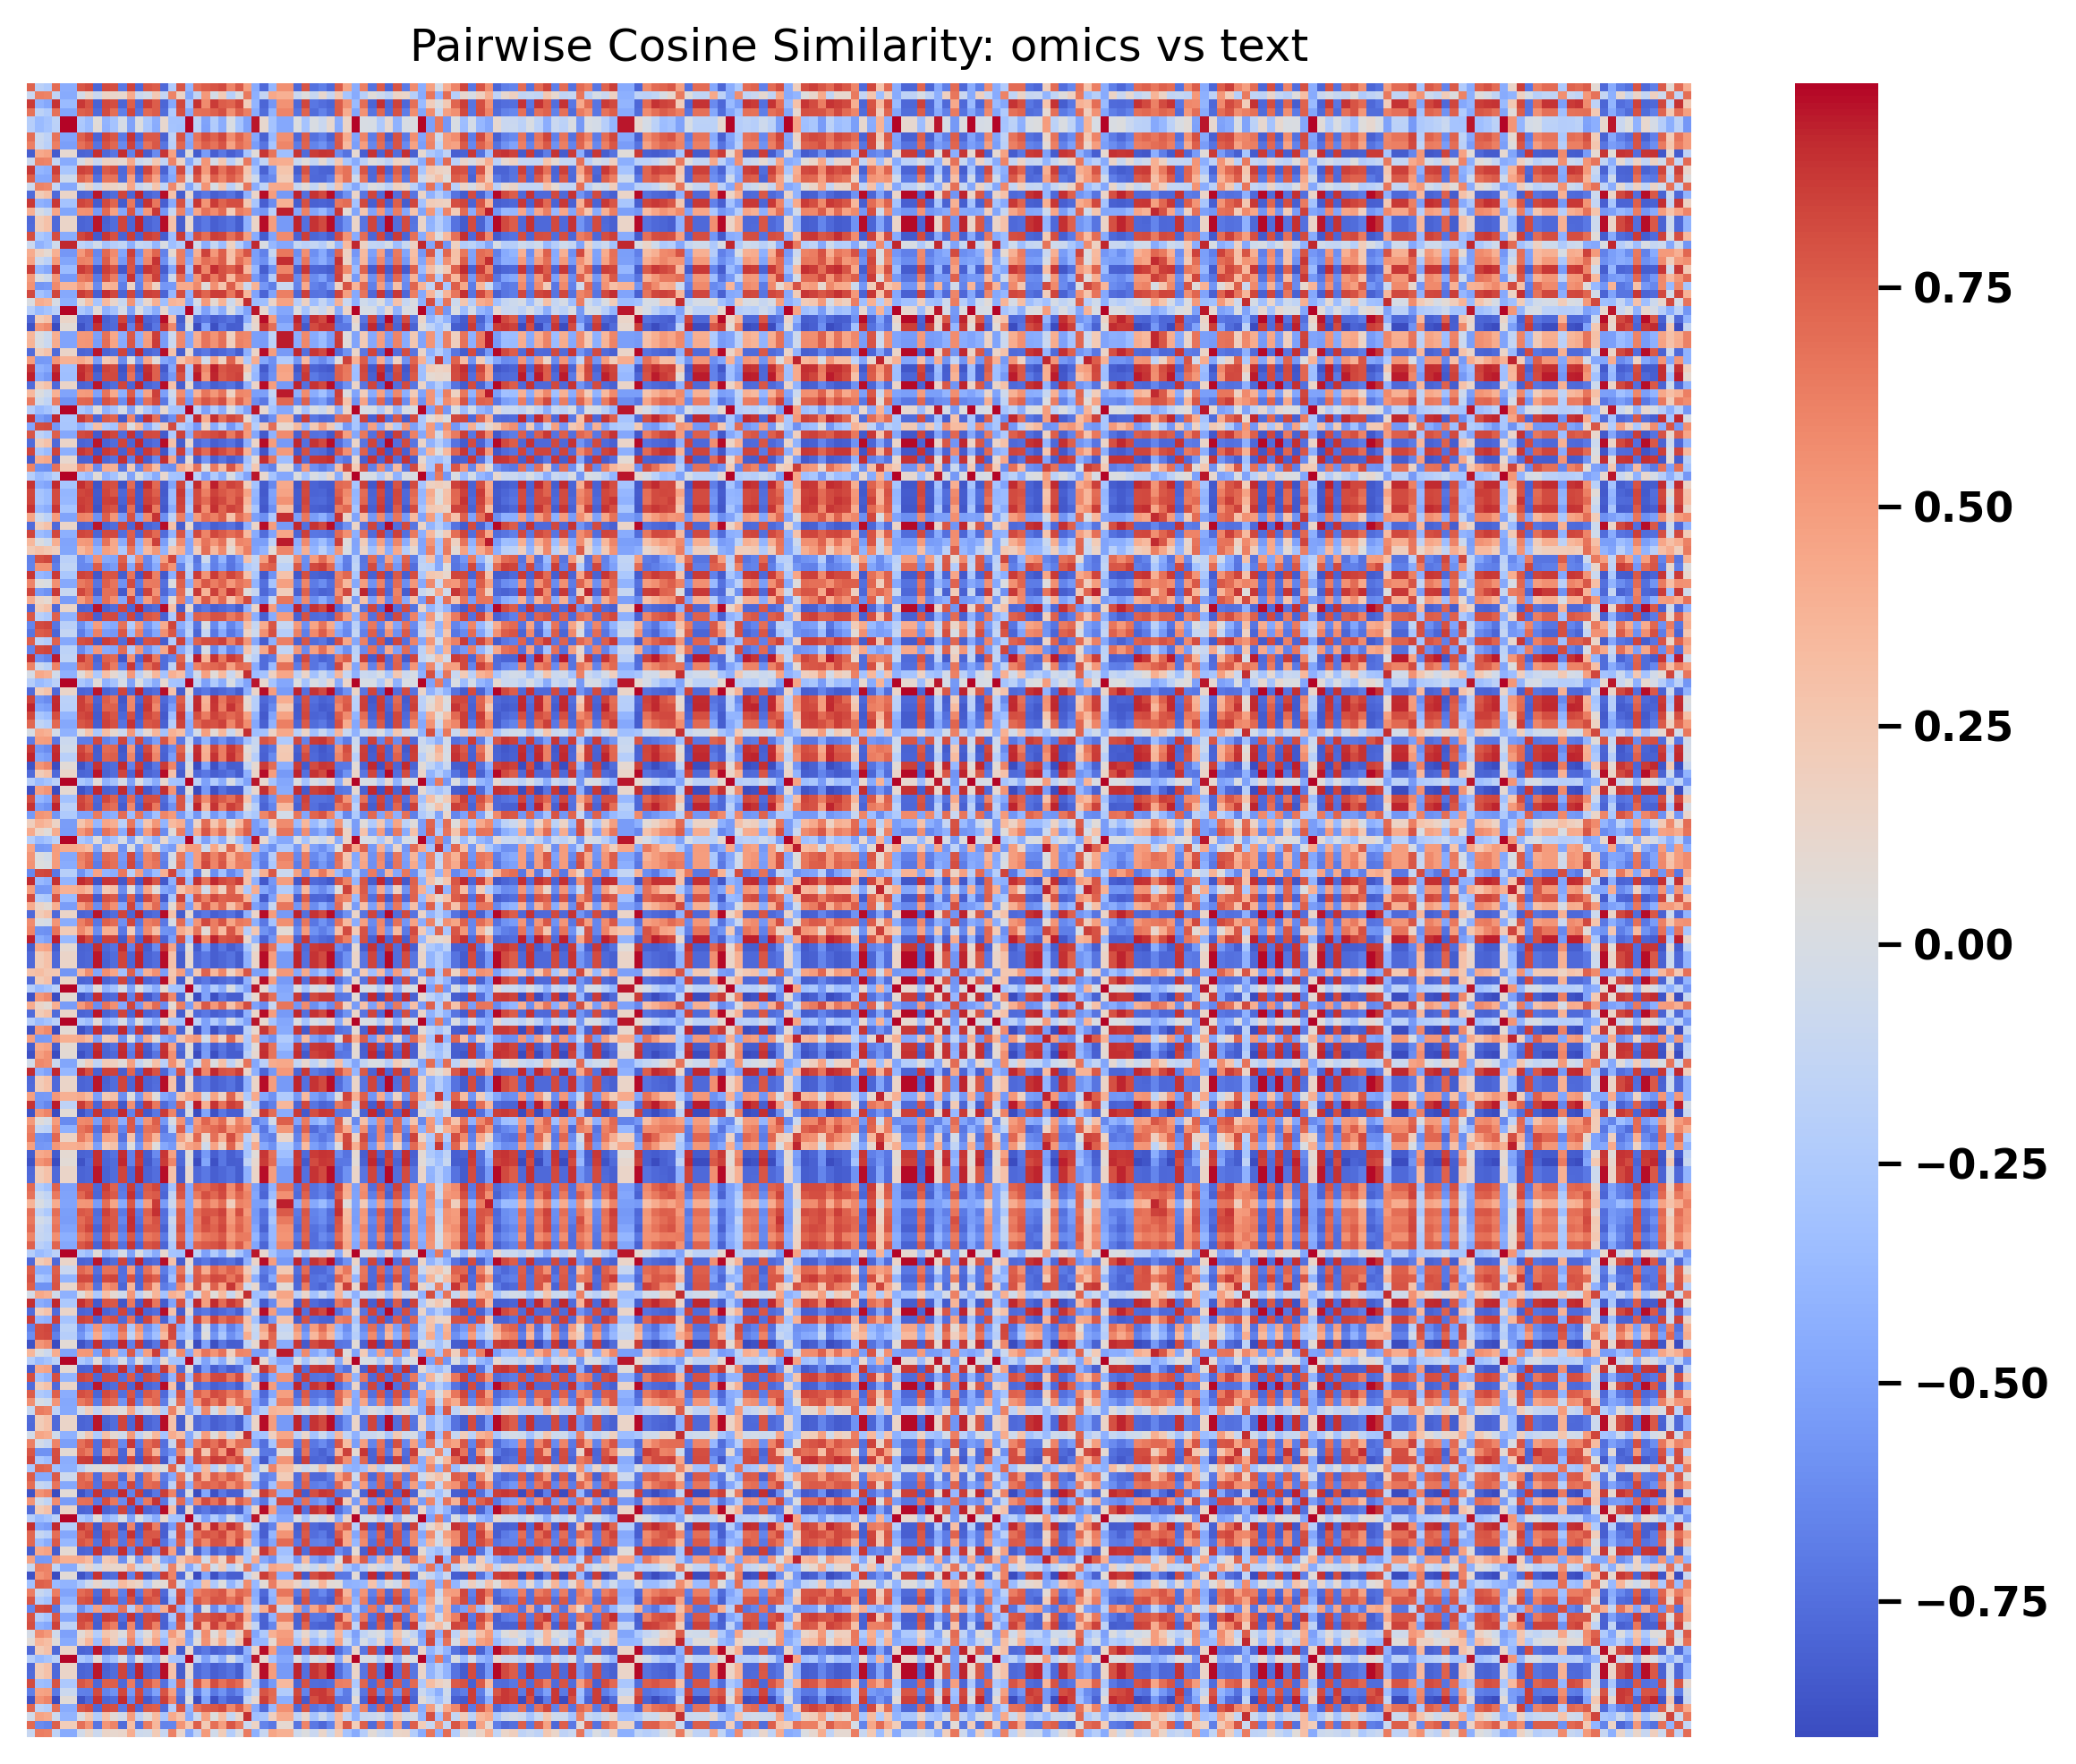

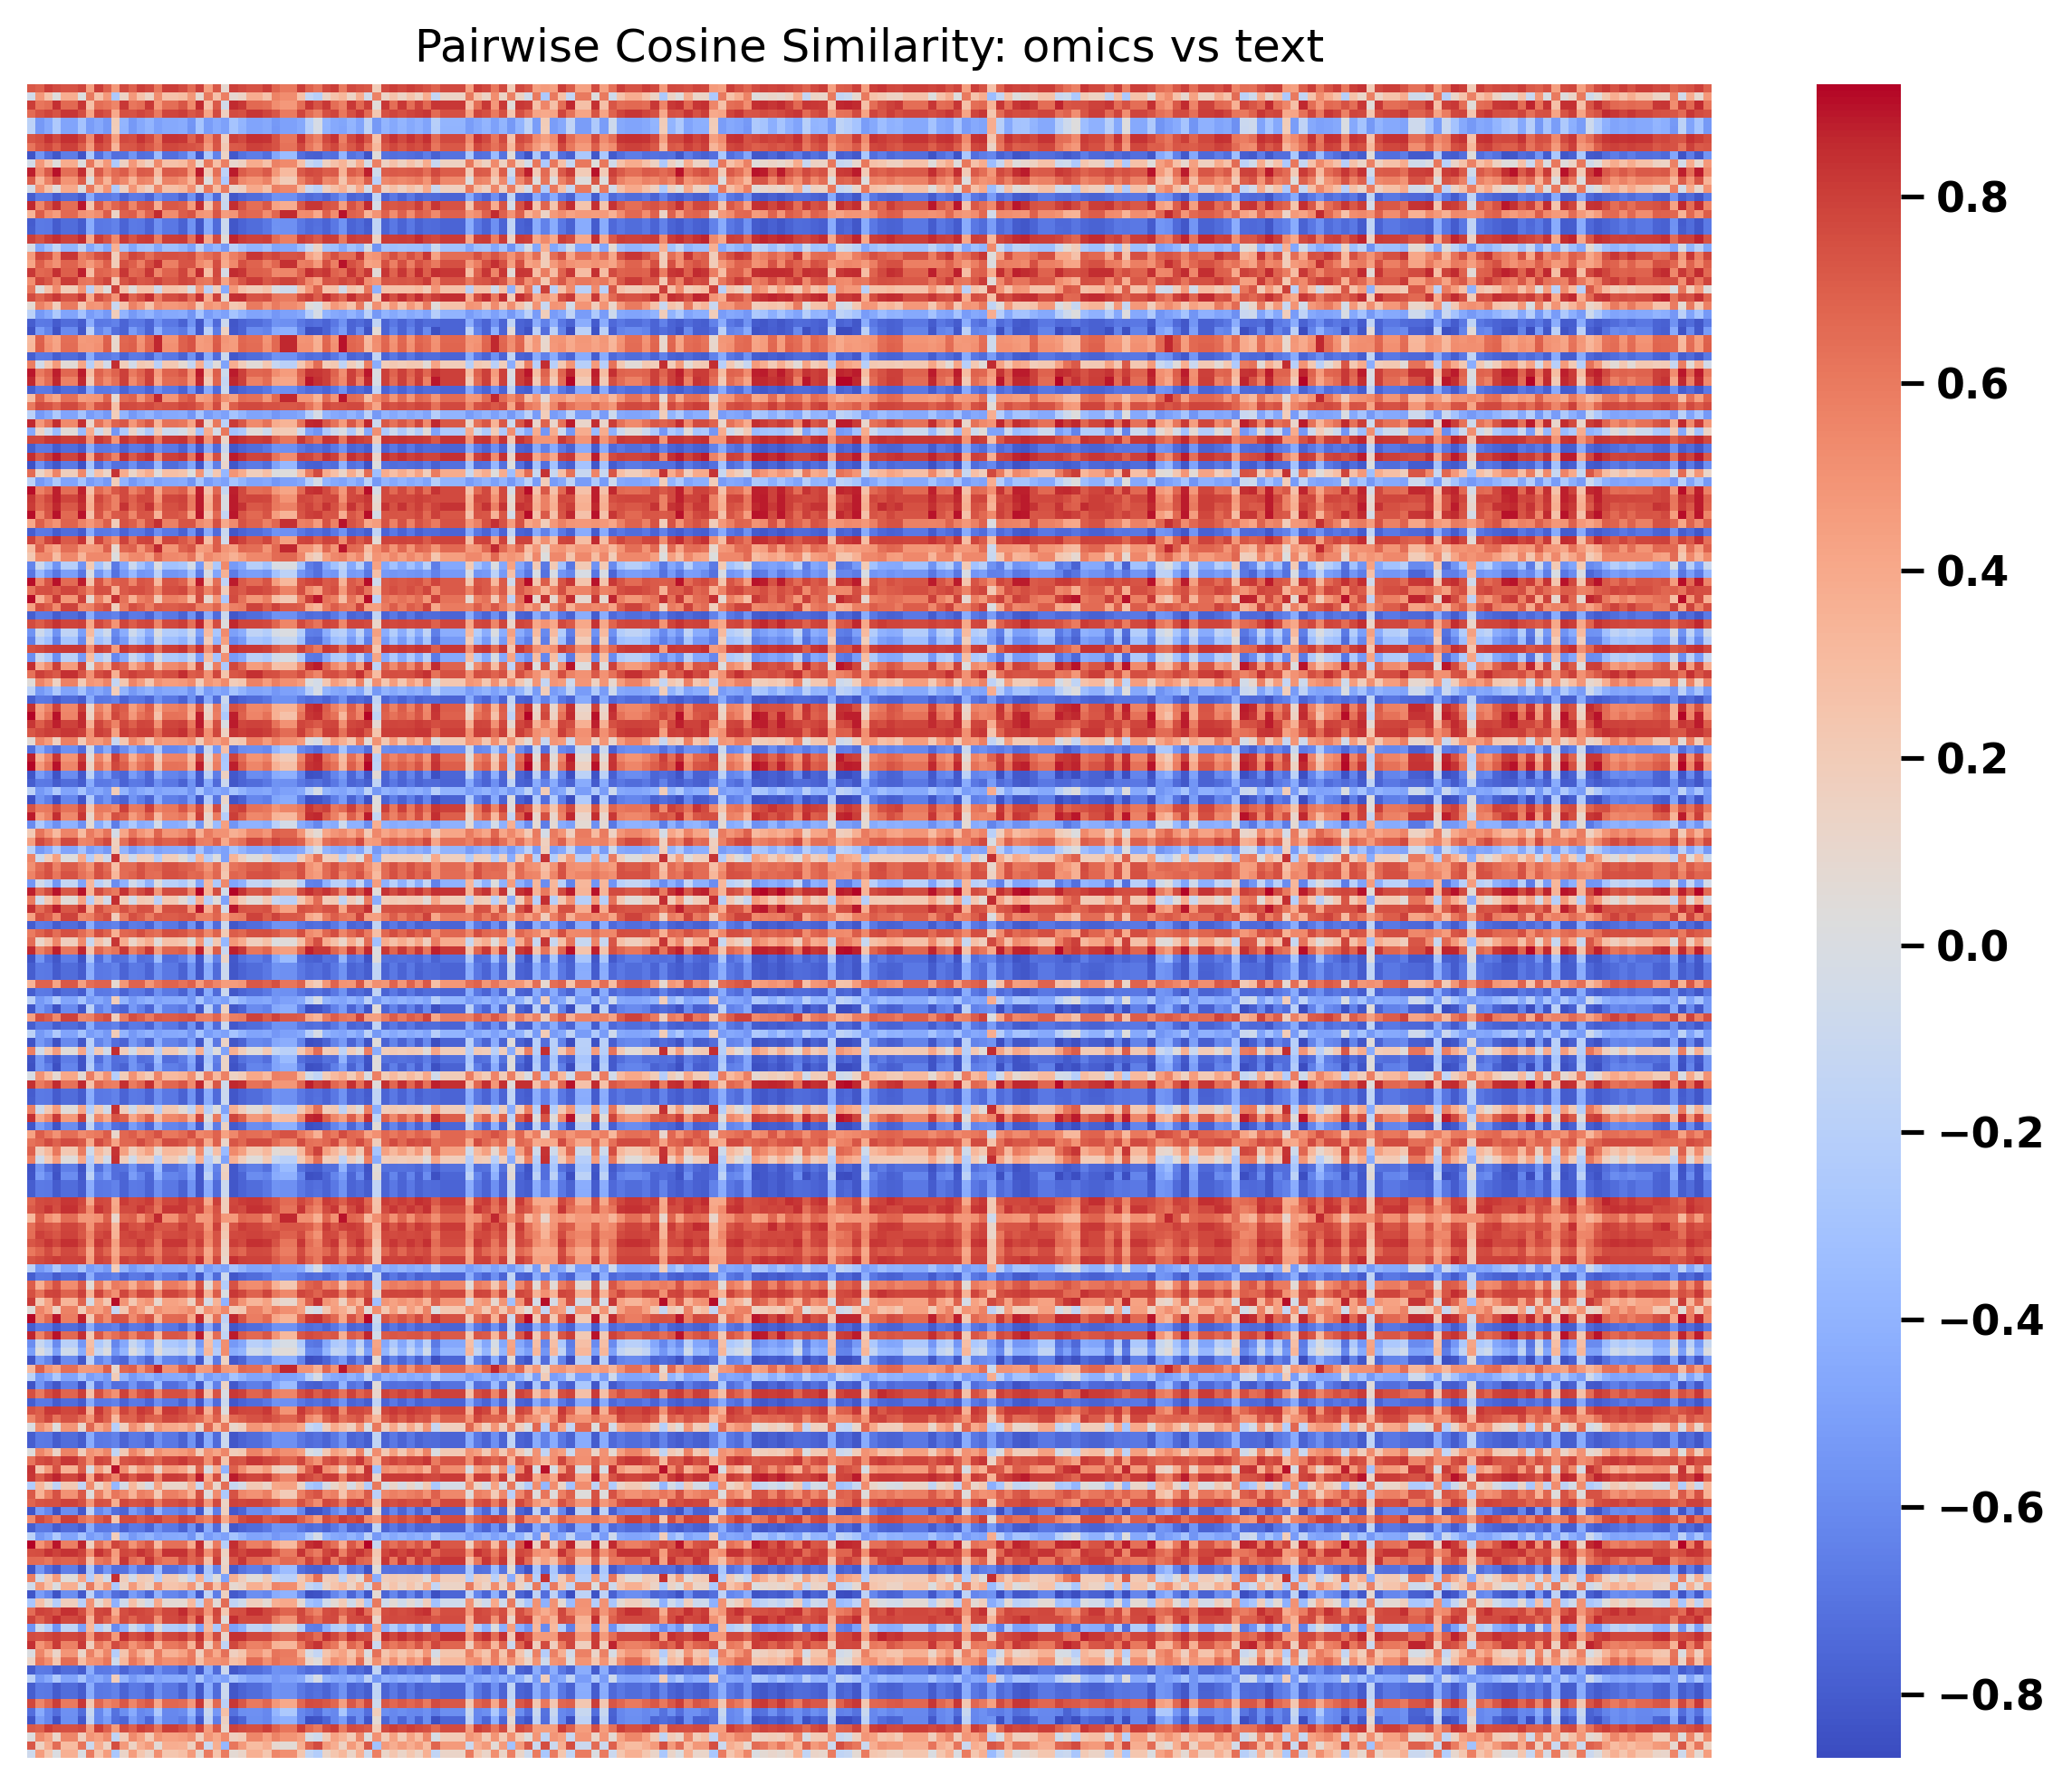

In [45]:
from mmcontext.pl.plotting import plot_embedding_similarity

SAVE_FIGURES = False
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=200, label_key="cell_type")

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_batch.png", dpi=150)

plot_embedding_similarity(emb_pair_df_tissue, emb1_type="omics", emb2_type="text", n_samples=200, label_key="tissue")

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_celltype.png", dpi=150)